# 03a - BigQuery Machine Learning (BQML) - Machine Learning with SQL

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of SQL to "CREATE MODEL …).  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

In this demonstration, BigQuery ML (BQML) is used to create a logistic regression model.

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:

<p><center><a href="https://youtu.be/IcVyP_ZAXmY" target="_blank" rel="noopener noreferrer"><img src="architectures/thumbnails/playbutton/03a.png" width="50%"></a></center></p>

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Overview:
-  Train logistic regression model with BQML
   -  CREATE MODEL …. model_type="LOGISTIC_REG"
-  Review training information
   -  SELECT * FROM ML.TRAINING_INFO…
-  Evaluated the models performance
   -  SELECT * FROM ML.EVALUATE…
-  Review the classification errors with a confusion matrix
   -  SELECT * FROM ML.CONFUSION_MATRIX…
-  Create prediction for data in BigQuery
   -  SELECT * FROM ML.PREDICT

### Resources:
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
-  [BigQuery magics for jupyter notebooks](https://github.com/GoogleCloudPlatform/bigquery-notebooks/blob/main/notebooks/official/template_notebooks/bigquery_magic.ipynb)


---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/03a_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/03a_console.png">

---
## Setup

inputs:

In [1]:
REGION = 'us-central1'
PROJECT_ID= 'ma-mx-presales-lab'
DATANAME = 'fraud'
NOTEBOOK = '03a'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [2]:
from google.cloud import bigquery

clients:

In [3]:
bigquery = bigquery.Client()

---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.

In [4]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

In [5]:
(job.ended-job.started).total_seconds()

153.053

Review the iterations from training:

In [6]:
bigquery.query(query=f"SELECT * FROM ML.TRAINING_INFO(MODEL `{DATANAME}.{DATANAME}_lr`) ORDER BY iteration").to_dataframe()

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.683162,0.682681,0.2,9460
1,0,1,0.645022,0.644344,0.4,11472
2,0,2,0.577285,0.576305,0.8,10462
3,0,3,0.470058,0.468706,1.6,9212
4,0,4,0.334091,0.332410,3.2,10563
5,0,5,0.216020,0.214082,6.4,11047
6,0,6,0.157163,0.154851,12.8,9951
7,0,7,0.117359,0.115373,25.6,10662


### Check out this model in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

---
## Evaluate Model

Review the model evaluation statistics on the Test/Train splits:

In [5]:
query = f"""
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TRAIN'))
UNION ALL
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TEST'))
"""
bigquery.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.105485,0.847458,0.984705,0.187617,0.113488,0.965440
1,TRAIN,0.086462,0.903797,0.983309,0.157825,0.116895,0.986058


Review the confusion matrix for each split:

In [7]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TRAIN')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,223141,4354
1,1,38,357


In [8]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'VALIDATE')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27870,525
1,1,5,49


In [9]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27878,547
1,1,5,38


---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [10]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
pred = bigquery.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [11]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [12]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.18414804910932128}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.17787665088281893}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.0929538802244257}, {'l...",TEST
3,0,0,"[{'label': 1, 'prob': 0.0730696295422579}, {'l...",TEST
4,0,0,"[{'label': 1, 'prob': 0.03393033841820178}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [14]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')  # The exec() method executes the dynamically created program, which is either a string or a code object.

[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.8158519508906787},
  {'label': 1, 'prob': 0.18414804910932128}]]

More on `exec`: https://www.programiz.com/python-programming/methods/built-in/exec

---
## Explanations
https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict

In [15]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bigquery.query(query = query).to_dataframe()

In [16]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.815852,"[{'feature': 'V4', 'attribution': 1.6549273582...",-2.753045,-1.488493,0.0,6126,-0.130702,1.026568,2.692793,...,-0.370958,-1.058635,-0.498915,0.054906,-0.590204,-0.537678,0.0,0,70526fff-bdf3-459f-bbc6-a18e8133bb35,TEST
1,0,0.822123,"[{'feature': 'V4', 'attribution': 0.9217155520...",-2.753045,-1.530800,0.0,32799,1.153477,-0.047859,1.358363,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e8b3c609-62a9-4ec3-9ff8-fd0974b07602,TEST
2,0,0.907046,"[{'feature': 'V4', 'attribution': 1.0802420933...",-2.753045,-2.278090,0.0,35599,1.168909,-0.139981,-0.095518,...,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0,c5ac2c63-c26b-492e-bc8e-5f98e92ec866,TEST
3,0,0.926930,"[{'feature': 'V4', 'attribution': -0.379555569...",-2.753045,-2.540466,0.0,49561,1.333331,-0.845997,1.161578,...,-0.095332,0.367347,0.398274,-0.059810,0.041674,0.011653,0.0,0,aca44b9b-e816-4767-b636-0356637c286b,TEST
4,0,0.966070,"[{'feature': 'V4', 'attribution': 0.3745584175...",-2.753045,-3.348926,0.0,75906,1.286617,0.069386,0.260252,...,-0.155584,-1.435878,0.502120,-0.419857,0.040041,0.007364,0.0,0,0ac882f3-6b09-4459-8d2b-25bae077a0c0,TEST


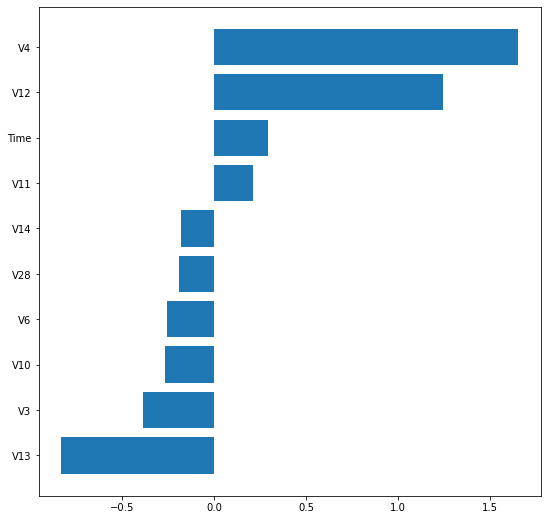

In [17]:
import matplotlib.pyplot as plt

features = []
scores = []
for k in explain.iloc[0]['top_feature_attributions']:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Remove Resources
see notebook "99 - Cleanup"